# Problem Statement
When someone look for nearby restaurants or plan an errand in an unknown area, he/she expect relevant, accurate information. Our task is to determine which place entries describe the same point-of-interest.

**Evaluation Method:**

Submissions are evaluated by the mean *Intersection over Union(IoU)* , aka the Jaccard index of the ground-truth entry matches and the predicted entry matches. The mean is taken sample-wise, meaning that an IoU score is calculated for each row in the submission file, and the final score is their average.

**What is Intersection over Union(IoU)  aka the Jaccard index?**
IoU(Intersection over Union) is a term used to describe the extent of overlap of two boxes. The greater the region of overlap, the greater the IoU.
IoU is majorly used in object detection problems, where model is trained to output a box that fits perfectly to object.

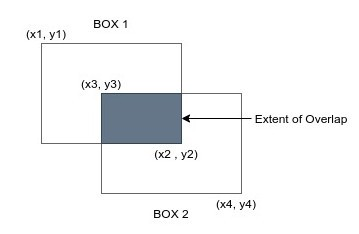

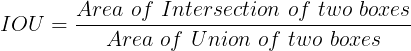

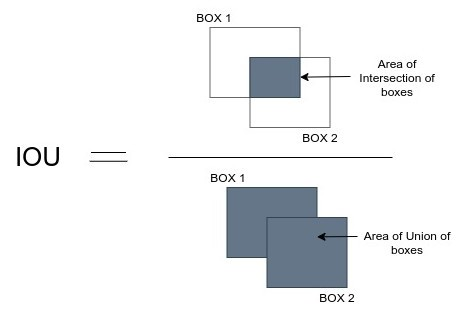

Credits to other notebook,
1. https://www.kaggle.com/code/remekkinas/eda-and-additional-feat-distance-adress-zip  by @remekkinas for Haversine distnace
1. https://www.kaggle.com/code/sudalairajkumar/flm-additional-match-pairs-data by @sudalairajkumar for Pairs data.

# Data Extraction

In [ ]:
pip install unidecode

In [ ]:
import numpy as np
import pandas as pd

import geopy
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline

from math import radians, cos, sin, asin, sqrt

from unidecode import unidecode

In [ ]:
BASE_PATH='../input/foursquare-location-matching/'
train_df =pd.read_csv(BASE_PATH + 'train.csv')
pair_df =pd.read_csv(BASE_PATH +'pairs.csv')
test_df =pd.read_csv(BASE_PATH +'test.csv')

In [ ]:
train_df.head(5)

In [ ]:
train_df.info()

In [ ]:
n = train_df.nunique(axis=0)  
print("No.of.unique values in each column :\n", n)

In [ ]:
train_df.isnull().sum()

There are no duplicate records.

In [ ]:
pair_df.info()

# EDA

In [ ]:
sns.histplot(x='latitude', data=train_df, bins=50)

In [ ]:
sns.histplot(x='longitude', data=train_df, bins=100)

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=train_df, x='longitude', y='latitude')

In [ ]:
plt.figure(figsize=(15,5))
train_df.groupby('country')['point_of_interest'].count().nlargest(20).plot.bar()

In [ ]:
plt.figure(figsize=(6,10))
train_df.groupby('categories')['point_of_interest'].count().nlargest(25).plot.barh()

In [ ]:
sns.countplot(x='match', data=pair_df)

In [ ]:
plt.figure(figsize=(6,10))
train_df.groupby('name')['point_of_interest'].count().nlargest(25).plot.barh()

# Feature Engineering

First lets calculate distance of each location from centre. We can do it with the help of Haversine distance method, whih is used to calculate distance between 2 locations.

The **Haversine distance(or great circle)** is the angular distance between two points on the surface of a sphere. The first coordinate of each point is assumed to be the latitude, the second is the longitude, given in radians.

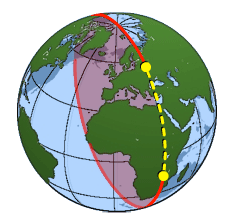

In [ ]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6371* c
    return km

In [ ]:
train_df['distance'] = [haversine(0,0,train_df.longitude[i],train_df.latitude[i]) for i in range(len(train_df))]
train_df['distance'] = train_df['distance'].round(decimals=3)

train_df.head()

In [ ]:
test_df['distance'] = [haversine(0,0,test_df.longitude[i],test_df.latitude[i]) for i in range(len(test_df))]
test_df['distance'] = test_df['distance'].round(decimals=3)

As suggested in data portion, we can generate additional pairs to improve your model's ability to discriminate POIs.
If we append to existing pair_df dataframe, it will duplicate records of existing True matched records.

In [ ]:
match_df = pd.merge(train_df, train_df, on="point_of_interest", suffixes=('_1', '_2'))
match_df = match_df[match_df["id_1"]!=match_df["id_2"]]
match_df = match_df.drop(["point_of_interest"], axis=1)
match_df["match"] = True
match_df.head(2)

In [ ]:
pair_df_upd = pair_df.append(match_df, ignore_index=True)

In [ ]:
print(sum(pair_df_upd.duplicated()))

In [ ]:
pair_df_upd = pair_df_upd.drop_duplicates(keep='first')

### Cleaning name column

In [ ]:
def isNaN(string):
    return string != string

In [ ]:
def Fnunidecode(line):
    try:
        if isNaN(line):
            return ''
        else:
            return unidecode(line)
    except:
        print("An exception occurred",line)

In [ ]:
train_df['name'] = train_df['name'].apply(Fnunidecode)

In [ ]:
train_df['name'] = train_df['name'].str.lower()

In [ ]:
import re
def RmvPunctuation(line):
    try:
        return re.sub(r'[^\w\s]','',line)
    except:
        print("An exception occurred",line)

In [ ]:
train_df['name'] = train_df['name'].apply(RmvPunctuation)

In [ ]:
train_df.head(5)

### Adding missing country

In [ ]:
train_df['country'] = train_df['country'].fillna('OT')

### Visualize data of a Point of Interest

In [ ]:
train_df.groupby('point_of_interest')['categories'].count().nlargest(25)

In [ ]:
def draw_lon_lat(df, world):
    geometry = [Point(xy) for xy in zip(df.longitude, df.latitude)]
    gdf = GeoDataFrame(df, geometry=geometry)   
    gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [ ]:
df = train_df[train_df['point_of_interest']=='P_f82d146eaf21da']

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
draw_lon_lat(df, world)

In [ ]:
df.name.value_counts()

# References:
1. https://medium.com/analytics-vidhya/iou-intersection-over-union-705a39e7acef
1. https://pypi.org/project/geopy/
1. https://www.kaggle.com/code/remekkinas/eda-and-additional-feat-distance-adress-zip